In [1]:
#Libraries import and device definition
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import random
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from PIL import Image
import os, os.path
import matplotlib.pyplot as plt
from skimage import io
from datetime import datetime
import time
import copy
%matplotlib inline
import numpy as np
import seaborn as sns; sns.set()
from torchsummary import summary
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device={device}')

Working on device=cuda


In [2]:
#Path set up
root_path = "c:/data/chest_xray/"

train_data_path = root_path + "train/"
test_data_path = root_path + "test/"

train_normal_path = train_data_path + "NORMAL/"
train_pneumonia_path = train_data_path + "PNEUMONIA/"

test_normal_path = test_data_path + "NORMAL/"
test_pneumonia_path = test_data_path + "PNEUMONIA/"

In [3]:
train_normal_dir = os.listdir(train_normal_path)
train_pneumonia_dir = os.listdir(train_pneumonia_path)

test_normal_dir = os.listdir(test_normal_path)
test_pneumonia_dir = os.listdir(test_pneumonia_path)

print("Number of normal x-rays (train): ", len(train_normal_dir))
print("Number of pneumonia x-rays (train): ", len(train_pneumonia_dir))

print("Number of normal x-rays (test): ", len(test_normal_dir))
print("Number of pneumonia x-rays (test): ", len(test_pneumonia_dir))

Number of normal x-rays (train):  1341
Number of pneumonia x-rays (train):  3875
Number of normal x-rays (test):  234
Number of pneumonia x-rays (test):  390


In [4]:
def plot_images(item_dir, top=10):
  dir = os.listdir(item_dir)
  all_files = [os.path.join(item_dir, file) for file in dir]
  top_files = np.random.choice(all_files, top)

  plt.figure(figsize = (15,15))
  for idx, img_path in enumerate(top_files):
    plt.subplot(5,5, idx+1)
    img = io.imread(img_path, as_gray=False)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
  plt.tight_layout()

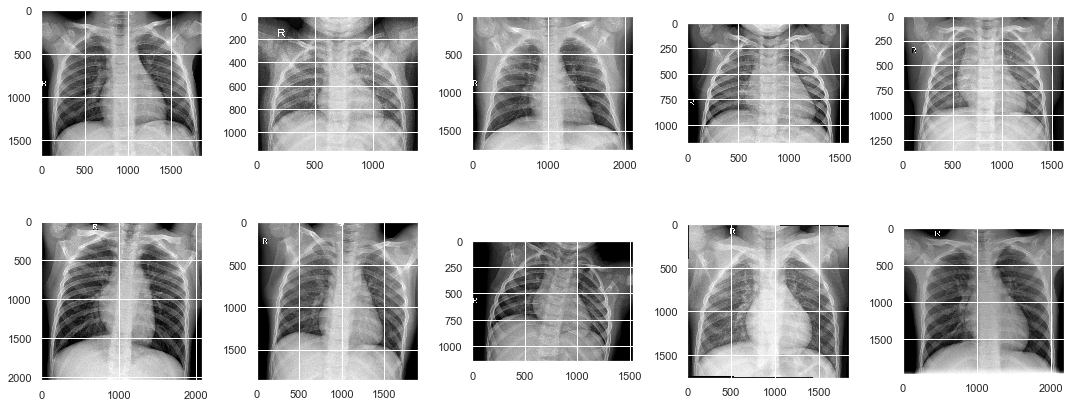

In [5]:
plot_images(train_normal_path)

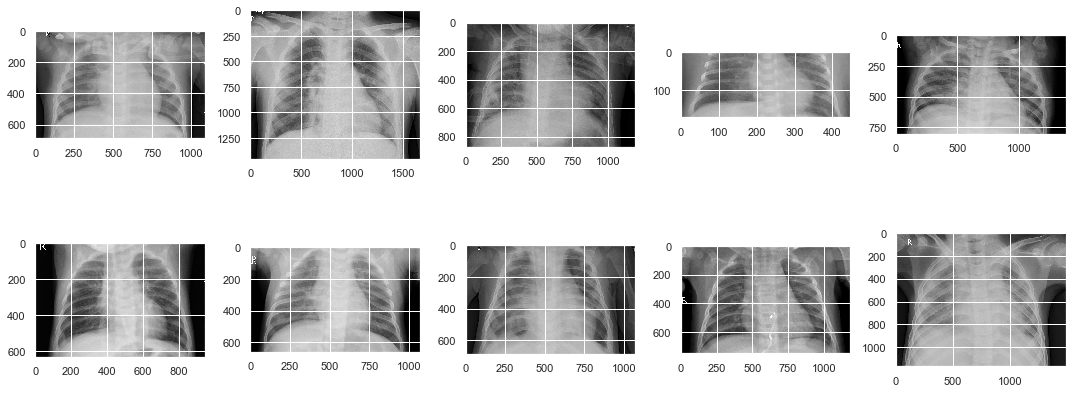

In [6]:
plot_images(train_pneumonia_path)

In [7]:

#Generating extra preprocessed images
def augment(img):
  par_1 = random.uniform(0.1, 1.0)
  par_2 = random.uniform(1.0, 15.0)
  par_3 = random.uniform(2.0, 40.0)
  par_4 = random.uniform(0.1, 1.0)
  par_5 = random.uniform(0.1, 1.0)
  par_6 = random.uniform(0.01, 0.2)
  affine = iaa.Affine(rotate=(-10, 10), mode = 'edge')
  img = affine.augment_image(img)
  blurer = iaa.GaussianBlur(iap.Uniform(0.1,par_1)) 
  img = blurer.augment_image(img)
  elastic = iaa.ElasticTransformation(sigma=par_2, alpha=par_3)
  img=elastic.augment_image(img)
  flp=iaa.Flipud(p=par_4)
  img=flp.augment_image(img)
  salt = iaa.SaltAndPepper(p=par_6)
  img=salt.augment_image(img)
  flp2=iaa.Fliplr(p=par_5)
  img=flp2.augment_image(img)
  crop = iaa.CropToFixedSize(1500,1300,position="center-bottom")
  img = crop.augment_image(img)
  return img

In [8]:

#Preprocessing and model variables
hight = 224
width = 224
channels = 1
batch_size = 1
num_classes = 2
num_epochs = 20
learning_rate = 0.001

transform = transforms.Compose(
    [transforms.Resize(size=(hight,width), interpolation=2),
     transforms.Grayscale(1),
     transforms.ToTensor(),
     transforms.Normalize((0.485,), (0.229,))])

classes = ('NORMAL', 'PNEUMONIA')

In [9]:
#Dataset and Dataloader definition
train_dataset = torchvision.datasets.ImageFolder(
        root=train_data_path,
        transform=transform,
    )
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )


test_dataset = torchvision.datasets.ImageFolder(
        root=test_data_path,
        transform=transform,
    )
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=False
    )


In [10]:
#Model definition
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        # channel_in=1 channels_out=16
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(16)  
        self.fc1 = nn.Linear(16 * 112 * 112, 512)
        self.dropout1 = nn.Dropout2d(0.3) 
        self.fc2 = nn.Linear(512,512)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc3 = nn.Linear(512,512)
        self.output = nn.Linear(512, 2)
        
    def forward(self, x):
        #print("Input data shape: ", x.shape)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.pool(x)
        #print("After last convolution process: ", x.shape)
        
        x = x.view(-1, 16 * 112 * 112) #16 channels 112x112 size
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.relu(x)      

        x = self.output(x)
        return x

In [11]:
#Model summary, loss function and optimizer definition
net = ConvNet()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
summary(net, (channels, hight, width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            Conv2d-4         [-1, 16, 224, 224]           2,320
       BatchNorm2d-5         [-1, 16, 224, 224]              32
              ReLU-6         [-1, 16, 224, 224]               0
         MaxPool2d-7         [-1, 16, 112, 112]               0
            Linear-8                  [-1, 512]     102,760,960
              ReLU-9                  [-1, 512]               0
        Dropout2d-10                  [-1, 512]               0
           Linear-11                  [-1, 512]         262,656
             ReLU-12                  [-1, 512]               0
        Dropout2d-13                  [-1, 512]               0
           Linear-14                  [

In [ ]:
#Model training
accuracy_index = []
losses_index = []
for epoch in range(num_epochs):  # loop over the dataset multiple times
    start_time = datetime.now()
    net.train()
    running_loss = 0.0
    epoch_loss = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        # move data to device GPU OR CPU
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss = epoch_loss / len(train_loader)
    time_elapsed = datetime.now() - start_time
    losses_index.append(epoch_loss)
    
    # Test the model, set our model in the training mode
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Accuracy of the network on the 10000 test images
    acc = correct/total
    accuracy_index.append(acc)
    
    
    print(
        f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f} Test acc: {acc:.4f} time={time_elapsed}')

Epoch [1/20], Loss: 1.2276 Test acc: 0.6250 time=0:04:59.282914
Epoch [2/20], Loss: 0.5961 Test acc: 0.6250 time=0:04:39.196098
Epoch [3/20], Loss: 0.5925 Test acc: 0.6010 time=0:04:41.220124
Epoch [4/20], Loss: 0.6298 Test acc: 0.6635 time=0:04:40.516074
Epoch [5/20], Loss: 0.3557 Test acc: 0.6939 time=0:04:39.531734
Epoch [6/20], Loss: 0.2769 Test acc: 0.7404 time=0:04:39.846462
Epoch [7/20], Loss: 0.2266 Test acc: 0.7228 time=0:04:43.920691
Epoch [8/20], Loss: 0.2107 Test acc: 0.7179 time=0:04:40.495202
Epoch [9/20], Loss: 0.1340 Test acc: 0.7308 time=0:04:36.092876
Epoch [10/20], Loss: 0.1552 Test acc: 0.7436 time=0:04:36.585557
Epoch [11/20], Loss: 0.1359 Test acc: 0.7131 time=0:04:36.257404
